# Evaluate and fit a ML model on the EC flux tower data

> NOTE: Use this notebook if testing, or if iterating on models to experiment with features and/or hyperparameters. It is not intended to be used for production runs. 

## Load modules

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sb
from scipy import stats
import lightgbm as lgbm
from pprint import pprint
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from scipy.stats import gaussian_kde
from joblib import dump, parallel_backend
from sklearn.ensemble import RandomForestRegressor

import shap
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## Analysis Parameters

In [2]:
model_var = 'GPP'
version = '20240214'
base = '/g/data/os22/chad_tmp/AusEFlux/'
n_cpus = 24
ec_exclusions=['DalyUncleared', 'RedDirtMelonFarm', 'Loxton']

modelling_vars = ['LST_RS', 'ΔT_RS',
                  'LAI_RS', 'LAI_anom_RS',
                  'kNDVI_RS','kNDVI_anom_RS',
                  'NDWI_RS','NDWI_anom_RS',
                  'trees_RS', 'grass_RS', 'bare_RS', 'C4_grass_RS',
                  'rain_RS', 'rain_cml3_RS', 'rain_anom_RS',
                  'rain_cml3_anom_RS', 'rain_cml6_anom_RS', 'rain_cml12_anom_RS',
                  'SRAD_RS', 'SRAD_anom_RS',
                  'Tavg_RS', 'Tavg_anom_RS',
                  'VPD_RS', 'VPD_anom_RS',
                  'VegH_RS', 'site'
                ]

## Prepare Data

In [3]:
sites = os.listdir(f'{base}data/training_data/')

fluxes=['NEE_SOLO_EC','GPP_SOLO_EC','ER_SOLO_EC','ET_EC']

td = []
for site in sites:
    if '.csv' in site:
        if any(exc in site for exc in ec_exclusions): #don't load the excluded sites
            print('skip', site[0:-4])
            continue
        else:
            xx = pd.read_csv(f'{base}data/training_data/{site}', index_col='time', parse_dates=True)
            xx['site'] = site[0:-4]
            xx = xx[fluxes+modelling_vars]
            td.append(xx)

ts = pd.concat(td).dropna() #we'll use this later

skip DalyUncleared
skip Loxton
skip RedDirtMelonFarm


In [4]:
xx = []
yy = []

for t in td:    
    t = t.dropna()  # remove NaNS
    df = t.drop(['NEE_SOLO_EC','GPP_SOLO_EC','ER_SOLO_EC'], axis=1) # seperate carbon fluxes
    
    df = df[modelling_vars]
    
    if model_var == 'ET':
        df_var=t[model_var+'_EC']
    else:
        df_var=t[model_var+'_SOLO_EC'] # seperate out the variable we're modelling
    
    x = df.reset_index(drop=True)#.to_numpy()
    y = df_var.reset_index(drop=True)#.to_numpy()
    xx.append(x)
    yy.append(y)

x = pd.concat(xx)
y = pd.concat(yy)

print(x.shape)

(3187, 24)


## Test model robustness with time-series K-fold cross validation

<!-- * If you set boosting as RF then the lightgbm algorithm behaves as random forest. According to the documentation, to use RF you must use bagging_fraction and feature_fraction smaller than 1 -->

### Generate five sets of train-test indices

For each site, grab a sequential set of test samples (time-series-split methods), the remaining points (either side of test samples) go into training.  A single K-fold contains test and training samples from every site.

In [5]:
sites = x['site'].unique()
x['original_index'] = [i for i in range(0,len(x))]

train_1=[]
train_2=[]
train_3=[]
train_4=[]
train_5=[]

test_1=[]
test_2=[]
test_3=[]
test_4=[]
test_5=[]

for site in sites:
    df = x.loc[x['site'] == site]
    tscv = TimeSeriesSplit(n_splits=5)
    i=1
    for train, test in tscv.split(df):
        all_indices=np.concatenate([train,test])
        left_over = df.loc[~df.index.isin(all_indices)].index.values
        train = np.concatenate([train, left_over])
        if i==1:
            train_1.append(df.iloc[train]['original_index'].values)
            test_1.append(df.iloc[test]['original_index'].values)
        if i==2:
            train_2.append(df.iloc[train]['original_index'].values)
            test_2.append(df.iloc[test]['original_index'].values)
        if i==3:
            train_3.append(df.iloc[train]['original_index'].values)
            test_3.append(df.iloc[test]['original_index'].values)
        if i==4:
            train_4.append(df.iloc[train]['original_index'].values)
            test_4.append(df.iloc[test]['original_index'].values)
        if i==4:
            train_5.append(df.iloc[train]['original_index'].values)
            test_5.append(df.iloc[test]['original_index'].values)
        i+=1

train_1 = np.concatenate(train_1)
train_2 = np.concatenate(train_2)
train_3 = np.concatenate(train_3)
train_4 = np.concatenate(train_4)
train_5 = np.concatenate(train_5)

test_1 = np.concatenate(test_1)
test_2 = np.concatenate(test_2)
test_3 = np.concatenate(test_3)
test_4 = np.concatenate(test_4)
test_5 = np.concatenate(test_5)

train = [train_1, train_2, train_3, train_4, train_5]
test = [test_1, test_2, test_3, test_4, test_5]

#check there are no train indices in the test indices
for i,j in zip(train, test):
    assert (np.sum(np.isin(i,j)) == 0)

#remove the columns we no longer need
x = x.drop(['site', 'original_index'], axis=1)

In [6]:
# Create the parameter grid using distributions
param_grid = {
    'num_leaves': stats.randint(5,50),
    'min_child_samples':stats.randint(10,30),
    'boosting_type': ['gbdt', 'dart'],
    'max_depth': stats.randint(5,25),
    'n_estimators': [200, 300, 400, 500],
}

### Write out text file of feature layers

In [7]:
textfile = open(f'{base}results/variables_{version}.txt', 'w')
for element in x.columns:
    textfile.write(element + ",")
textfile.close()

## Conduct nested cross-validation

In [8]:
# lists to store results of CV testing
acc = []
rmse=[]
r2=[]

i = 1
for train_index, test_index in zip(train, test):
    print(f"Working on {i}/{len(train)} outer cv split", end='\r')

    # index training, testing
    X_tr, X_tt = x.iloc[train_index, :], x.iloc[test_index, :]
    y_tr, y_tt = y.iloc[train_index], y.iloc[test_index]
    
    #simple random split on inner fold
    inner_cv = KFold(n_splits=5,
                     shuffle=True,
                     random_state=0)
    
    with parallel_backend('threading', n_jobs=n_cpus):
        model = LGBMRegressor(random_state=1, verbose=-1)
        clf = RandomizedSearchCV(
                           model,
                           param_grid,
                           verbose=0,
                           n_iter=10,
                           n_jobs=n_cpus,
                           cv=inner_cv.split(X_tr, y_tr),
                          )
        clf.fit(X_tr, y_tr, callbacks=None)
    
    # predict using the best model
    best_model = clf.best_estimator_
    pred = best_model.predict(X_tt)

    # evaluate model w/ multiple metrics
    # r2
    r2_ = r2_score(y_tt, pred)
    r2.append(r2_)
    # MAE
    ac = mean_absolute_error(y_tt, pred)
    acc.append(ac)
    # RMSE
    rmse_ = np.sqrt(mean_squared_error(y_tt, pred))
    rmse.append(rmse_)
    
    #1:1 plots for each fold (save to csv so we can make a plot later on)
    df = pd.DataFrame({'Test':y_tt, 'Pred':pred}).reset_index(drop=True)

    df.to_csv(f'{base}results/cross_val/{i}_{model_var}_lgbm.csv')
    i += 1

### Print accuracy results

In [9]:
print(f'Mean MAE accuracy: {np.mean(acc)}')
print(f'Std dev of MAE accuracy: {np.std(acc)}')
print('\n')
print(f'Mean RMSE: {np.mean(rmse)}')
print(f'Std dev RMSE: {np.std(rmse)}')
print('\n')
print(f'Mean r2: {np.mean(r2)}')
print(f'Std dev r2: {np.std(r2)}')

Mean MAE accuracy: 19.69094938782343
Std dev of MAE accuracy: 1.0925956176355829


Mean RMSE: 27.535912009474224
Std dev RMSE: 2.1820512618096406


Mean r2: 0.9015426269381924
Std dev r2: 0.006137188510898102


### Create a single 1:1 plot out of the folds 

None of the test samples overlap between folds, and every sample has been tested


In [10]:
dffs=[]
for i in range(1,len(train)+1):
    df = pd.read_csv(f'{base}results/cross_val/{i}_{model_var}_lgbm.csv', usecols=['Test', 'Pred'])
    dffs.append(df)
  
cross_df = pd.concat(dffs)

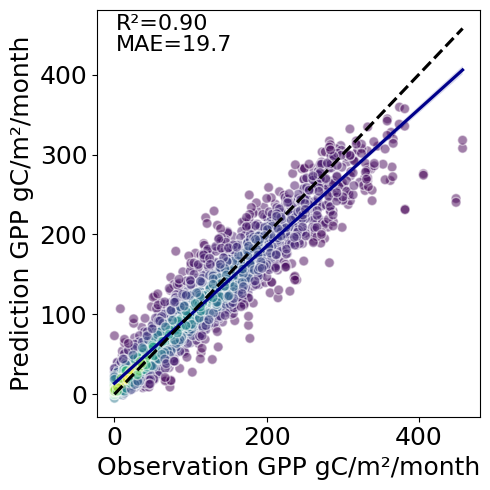

In [11]:
fig,ax = plt.subplots(1,1, figsize=(5,5))

xy = np.vstack([cross_df['Test'],cross_df['Pred']])
z = gaussian_kde(xy)(xy)

sb.scatterplot(data=cross_df, x='Test',y='Pred',c=z, s=50, lw=1, alpha=0.5, ax=ax)
sb.regplot(data=cross_df, x='Test',y='Pred', scatter=False, color='darkblue', ax=ax)
sb.regplot(data=cross_df, x='Test',y='Test', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax);

if model_var !='ET':
    units = ' gC/m\N{SUPERSCRIPT TWO}/month'
else:
    units = ' mm/month'

plt.xlabel('Observation '+ model_var + units, fontsize=18)
plt.ylabel('Prediction ' + model_var+ units, fontsize=18)
ax.text(.05, .95, 'R\N{SUPERSCRIPT TWO}={:.2f}'.format(np.mean(r2)),
            transform=ax.transAxes, fontsize=16)
ax.text(.05, .9, 'MAE={:.3g}'.format(np.mean(acc)),
            transform=ax.transAxes, fontsize=16)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

plt.tight_layout()
fig.savefig(f'{base}results/cross_val/cross_val_{model_var}_lgbm.png',
            bbox_inches='tight', dpi=300)           

## Optimize model using all training data

Using a randomized strategy so we can search through more variables, with 500 iterations

In [12]:
with parallel_backend('threading', n_jobs=n_cpus):
    clf = RandomizedSearchCV(
                           LGBMRegressor(verbose=-1),
                           param_grid,
                           verbose=1,
                           n_iter=50,
                           cv=zip(train, test), #using timeseries custom splits here
                          )
    clf.fit(x, y, callbacks=None)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [13]:
print("The most accurate combination of tested parameters is: ")
pprint(clf.best_params_)
print('\n')
print("The best score using these parameters is: ")
print(round(clf.best_score_, 2))

The most accurate combination of tested parameters is: 
{'boosting_type': 'dart',
 'max_depth': 12,
 'min_child_samples': 10,
 'n_estimators': 500,
 'num_leaves': 24}


The best score using these parameters is: 
0.9


## Fit on all data using best params


In [14]:
model = LGBMRegressor(**clf.best_params_)

model.fit(x,y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5601
[LightGBM] [Info] Number of data points in the train set: 3187, number of used features: 23
[LightGBM] [Info] Start training from score 117.873833


LGBMRegressor(boosting_type='dart', max_depth=12, min_child_samples=10,
              n_estimators=500, num_leaves=24)

## Save the models

In [15]:
dump(model, f'{base}results/models/{model_var}_LGBM_model_{version}.joblib')

['/g/data/os22/chad_tmp/AusEFlux/results/models/GPP_LGBM_model_20240214.joblib']

## Examine feature importance using SHAP

In [16]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(x)

In [17]:
vals= np.abs(shap_values.values).mean(0)
feature_importance = pd.DataFrame(list(zip(x.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance['col_name'] = feature_importance['col_name'].str.removesuffix("_RS")

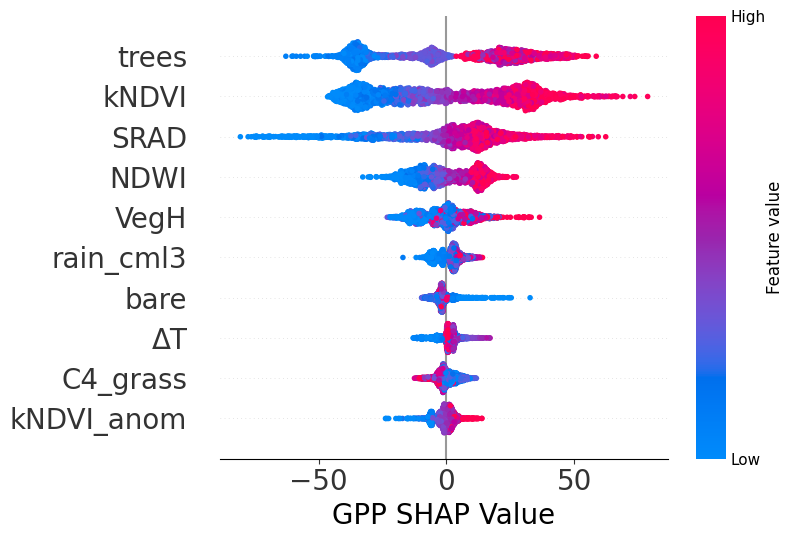

In [18]:
fig, ax = plt.subplots(1,1, figsize=(5,11))
shap.summary_plot(shap_values, max_display=10, show=False, feature_names=feature_importance['col_name'])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(15) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_xlabel(model_var+' SHAP Value', fontsize=20)
plt.tight_layout()
fig.savefig(f'{base}results/cross_val/feature_importance_{model_var}_lgbm.png',
           bbox_inches='tight', dpi=300)

### Dependency scatter plots (including main interaction effect)

showing the effect a single features have on the predictions made by the model

### First plots show the dependence for the top 4 predictors

In [19]:
font=28

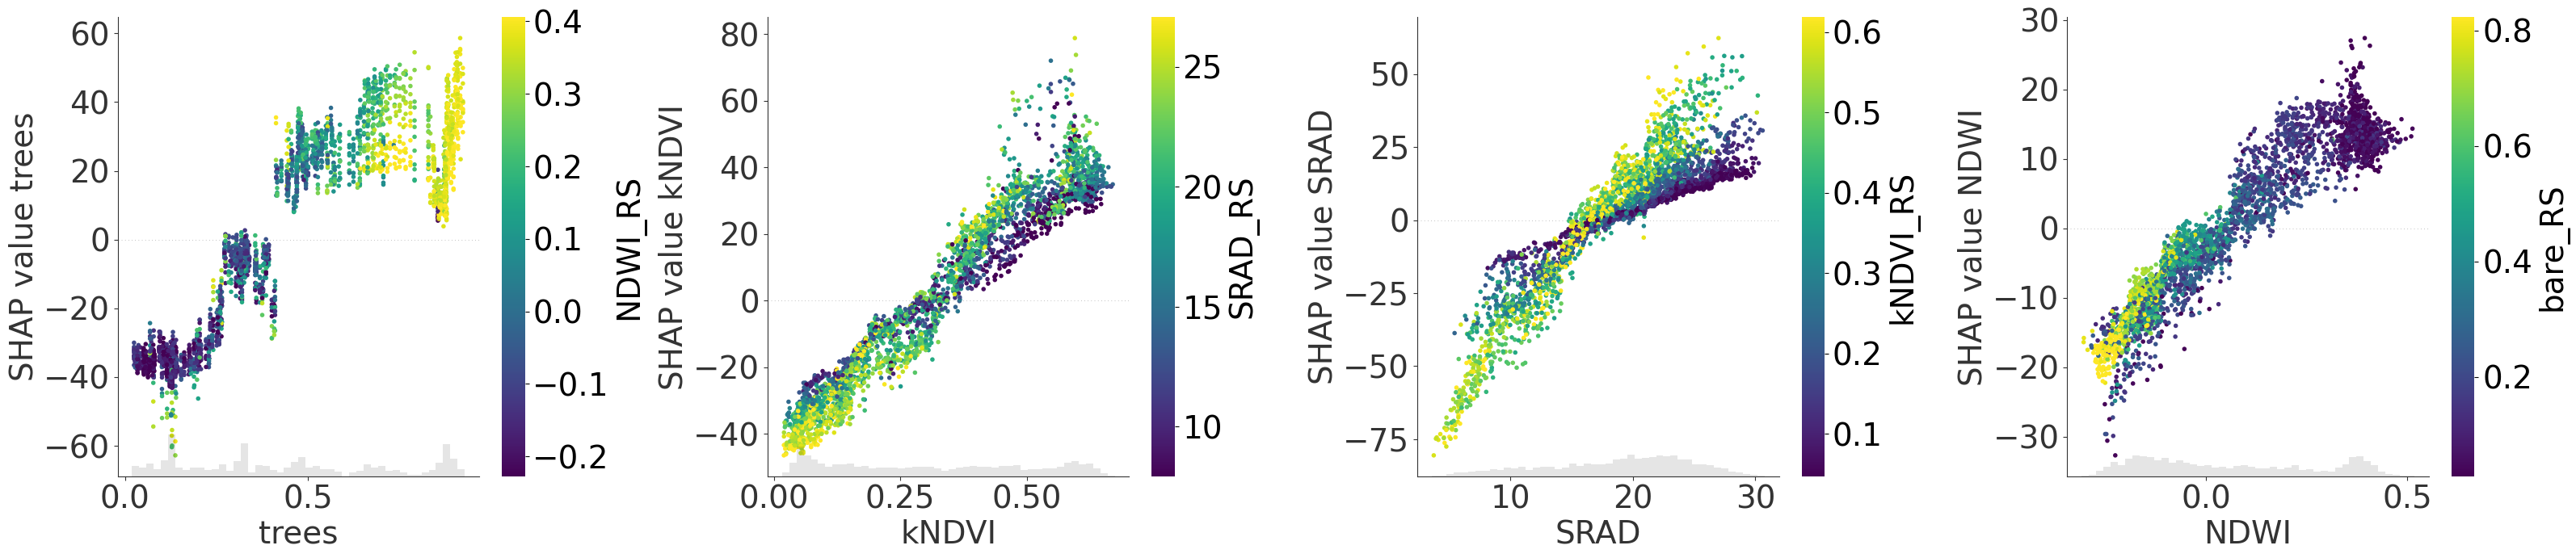

In [20]:
fig, axs = plt.subplots(1,4, figsize=(32,7))

for ax, feature in zip(axs.ravel(), list(feature_importance['col_name'])[0:4]):
    shap.plots.scatter(shap_values[:,feature+'_RS'], ax=ax, show=False, color=shap_values, cmap='viridis')
    ax.set_ylabel('SHAP value '+ feature,  fontsize=font)
    ax.set_xlabel(feature, fontsize=font)
    ax.tick_params(axis='x', labelsize=font)
    ax.tick_params(axis='y', labelsize=font)
    plt.gcf().axes[-2].set_aspect('auto')
    plt.gcf().axes[-2].set_box_aspect(20)
    plt.gcf().axes[-2].yaxis.label.set_fontsize(font)
    plt.gcf().axes[-2].tick_params(axis='y', labelsize=font)
plt.tight_layout()
fig.savefig(f'{base}results/cross_val/interaction_scatter_{model_var}_lgbm.png',
           bbox_inches='tight', dpi=300)

### Second plots show the dependence for the four main climate predictors (with kNDVI interaction)

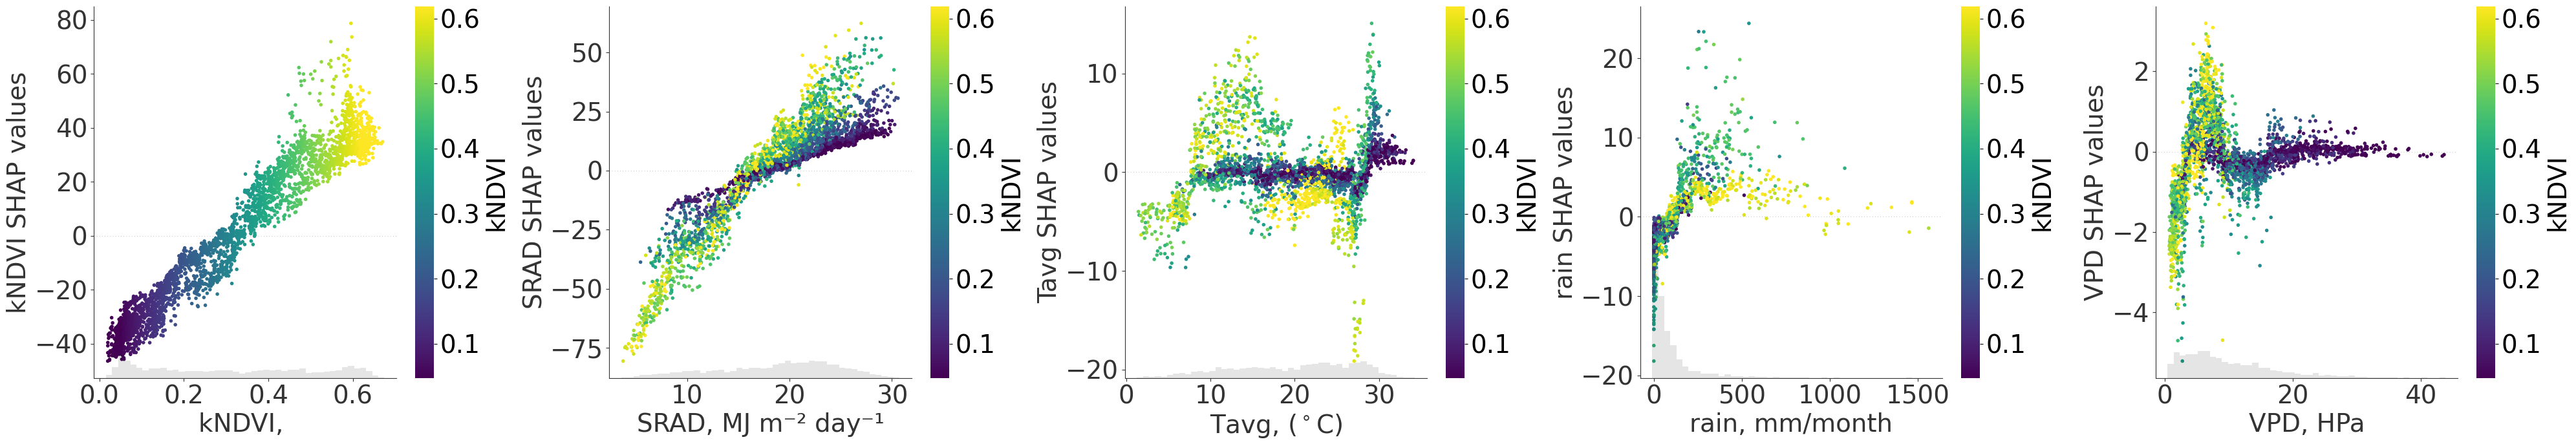

In [21]:
fig, axs = plt.subplots(1,5, figsize=(40,7))

for ax, feature, units in zip(axs.ravel(), ['kNDVI', 'SRAD', 'Tavg', 'rain', 'VPD'],
                ['', 'MJ m⁻\N{SUPERSCRIPT TWO} day⁻¹', '($^\circ$C)', 'mm/month', 'HPa']):
    if feature =='NDVI':
        shap.plots.scatter(shap_values[:,feature+'_RS'], ax=ax, show=False, color=shap_values, cmap='viridis')
    else:
        shap.plots.scatter(shap_values[:,feature+'_RS'], ax=ax, show=False, color=shap_values[:,'kNDVI_RS'], cmap='viridis')
        plt.gcf().axes[-2].set_ylabel('kNDVI')
    ax.set_ylabel(feature+' SHAP values',  fontsize=font)
    ax.set_xlabel(feature+', '+units+'', fontsize=font)
    ax.tick_params(axis='x', labelsize=font)
    ax.tick_params(axis='y', labelsize=font)
    plt.gcf().axes[-2].set_aspect('auto')
    plt.gcf().axes[-2].set_box_aspect(20)
    plt.gcf().axes[-2].yaxis.label.set_fontsize(font)
    plt.gcf().axes[-2].tick_params(axis='y', labelsize=font)
plt.tight_layout()
fig.savefig(f'{base}results/cross_val/interaction_scatter_climatevars{model_var}_lgbm.png',
            bbox_inches='tight', dpi=300)